In [1]:
# import packages
import xarray as xr
import numpy as np
import pandas as pd
import cftime
import netCDF4 as nc
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#from cartopy.util import add_cyclic_point
from glob import glob
#from shapely import geometry
import colormaps as cmaps
import os

# import helper functions
from functions.add_cyclic_point_to_dataset import add_cyclic_point_to_dataset
#from functions.fixTimeCESM import fixTimeCESM
from functions.adjustLon180 import adjustLon180
from functions.plottingFunctions import *

# function for updating the CESM time output
def fixTimeCESM(ds):
    # fix time array for CESM output (update array to start in January instead of February)
    # Known issue: https://bb.cgd.ucar.edu/cesm/threads/output-date-error-monthly-history-files-shifted-1-month.2078/
    time = ds.time.values
    first_date=time[0]
    
    new_first_date =cftime.DatetimeNoLeap(year=first_date.year, month=1, day=1, has_year_zero=first_date.has_year_zero)
    time = np.insert(time,0,new_first_date)
    time = time[:-1].copy()
    ds['time'] = time
    #print('The first date in the time vector is: ' + str(ds.time[0]))
    return ds

In [2]:
dataPath = '/Users/alawman2023/Documents/Data/Hosing/FromCJ/Freshwater Hosing experiments/'

# selected climate variable (e.g., zonal winds) and atmospheric level (hPa)
climVar = 'U'
selLev = '200'
climVariTraCe = 'U200'
climVarIPSL = 'u200'

#-----------------------------------------------
# CESM1 simulations - monthly climatology files
#-----------------------------------------------
simulations = ['b.e12.B1850C5.f19_g16.21ka.010.cam.clim.0001-0600.nc',
              'b.e12.21kaPMIP3.Hose01SvNA.001.cam.clim.0051-0100.nc',
              'b.e12.21kaPMIP3.Hose02SvNA.001.cam.clim.0101-0200.nc',
              'b.e12.21kaPMIP3.Hose015SvNA.001.cam.clim.0051-0100.nc']

# control simulation
fileC = 'b.e12.B1850C5.f19_g16.21ka.010.cam.clim.0001-0600.nc'
dsC_CESM1 = xr.open_dataset(dataPath + fileC)
lev_CESM = dsC_CESM1.lev
dsC_CESM1 = adjustLon180(dsC_CESM1)
dsC_CESM1 = add_cyclic_point_to_dataset(dsC_CESM1, 'U')
dsC_CESM1 = dsC_CESM1[climVar].sel(lev= selLev, method='nearest')
dsC_CESM1 = dsC_CESM1[5:8].mean(dim='time') #JJA

# hosing simulations (CESM1-0.1Sv, CESM1-0.15Sv, CESM1-0.20Sv) 
file1 = 'b.e12.21kaPMIP3.Hose01SvNA.001.cam.clim.0051-0100.nc'
file2 = 'b.e12.21kaPMIP3.Hose02SvNA.001.cam.clim.0101-0200.nc'
file3 = 'b.e12.21kaPMIP3.Hose015SvNA.001.cam.clim.0051-0100.nc'

ds_01Sv = xr.open_dataset(dataPath + file1)
ds_01Sv = adjustLon180(ds_01Sv)
ds_01Sv = add_cyclic_point_to_dataset(ds_01Sv, 'U')
ds_01Sv = ds_01Sv[climVar].sel(lev= selLev, method='nearest')
ds_01Sv = ds_01Sv[5:8].mean(dim='time') #JJA

ds_02Sv = xr.open_dataset(dataPath + file2)
ds_02Sv = adjustLon180(ds_02Sv)
ds_02Sv = add_cyclic_point_to_dataset(ds_02Sv, 'U')
ds_02Sv = ds_02Sv[climVar].sel(lev= selLev, method='nearest')
ds_02Sv = ds_02Sv[5:8].mean(dim='time') #JJA

ds_015Sv = xr.open_dataset(dataPath + file3)
ds_015Sv = adjustLon180(ds_015Sv)
ds_015Sv = add_cyclic_point_to_dataset(ds_015Sv, 'U')
ds_015Sv = ds_015Sv[climVar].sel(lev= selLev, method='nearest')
ds_015Sv = ds_015Sv[5:8].mean(dim='time') #JJA

# hosing minus control (individual simulations)
hose_CESM1_010 = ds_01Sv - dsC_CESM1
hose_CESM1_020 = ds_02Sv - dsC_CESM1
hose_CESM1_015 = ds_015Sv - dsC_CESM1

# ensemble mean CESM1 hosing simulations
hose_CESM1_ens = (hose_CESM1_010 + hose_CESM1_020 + hose_CESM1_015)/3
hose_CESM1_ens

<xarray.DataArray 'U' (lat: 96, lon: 145)>
array([[ 0.05806379,  0.05315322,  0.04814154, ...,  0.06754407,
         0.06286379,  0.05806379],
       [ 0.10318808,  0.09763435,  0.09195825, ...,  0.11383712,
         0.10859609,  0.10318808],
       [ 0.11192518,  0.10501311,  0.098086  , ...,  0.12556617,
         0.11878637,  0.11192518],
       ...,
       [-0.51192576, -0.53049135, -0.5471201 , ..., -0.46918416,
        -0.49147186, -0.51192576],
       [-0.5449505 , -0.57818365, -0.60998815, ..., -0.47447738,
        -0.51035863, -0.5449505 ],
       [-0.47392344, -0.5161665 , -0.5574271 , ..., -0.38681307,
        -0.43077818, -0.47392344]], dtype=float32)
Coordinates:
    lev      float64 197.9
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 175.0 177.5 180.0

In [3]:
# Define the new latitude and longitude coordinates to interpolate the IPSL-CM5 and CCSM3-1Sv-NA data to the CESM1 grid
new_lats = dsC_CESM1.lat
new_lons = dsC_CESM1.lon
new_lev = lev_CESM

Text(0.5, 1.0, 'CESM1-0.1Sv, 0.15 and 0.20 Sv ensemble mean (JJA)')

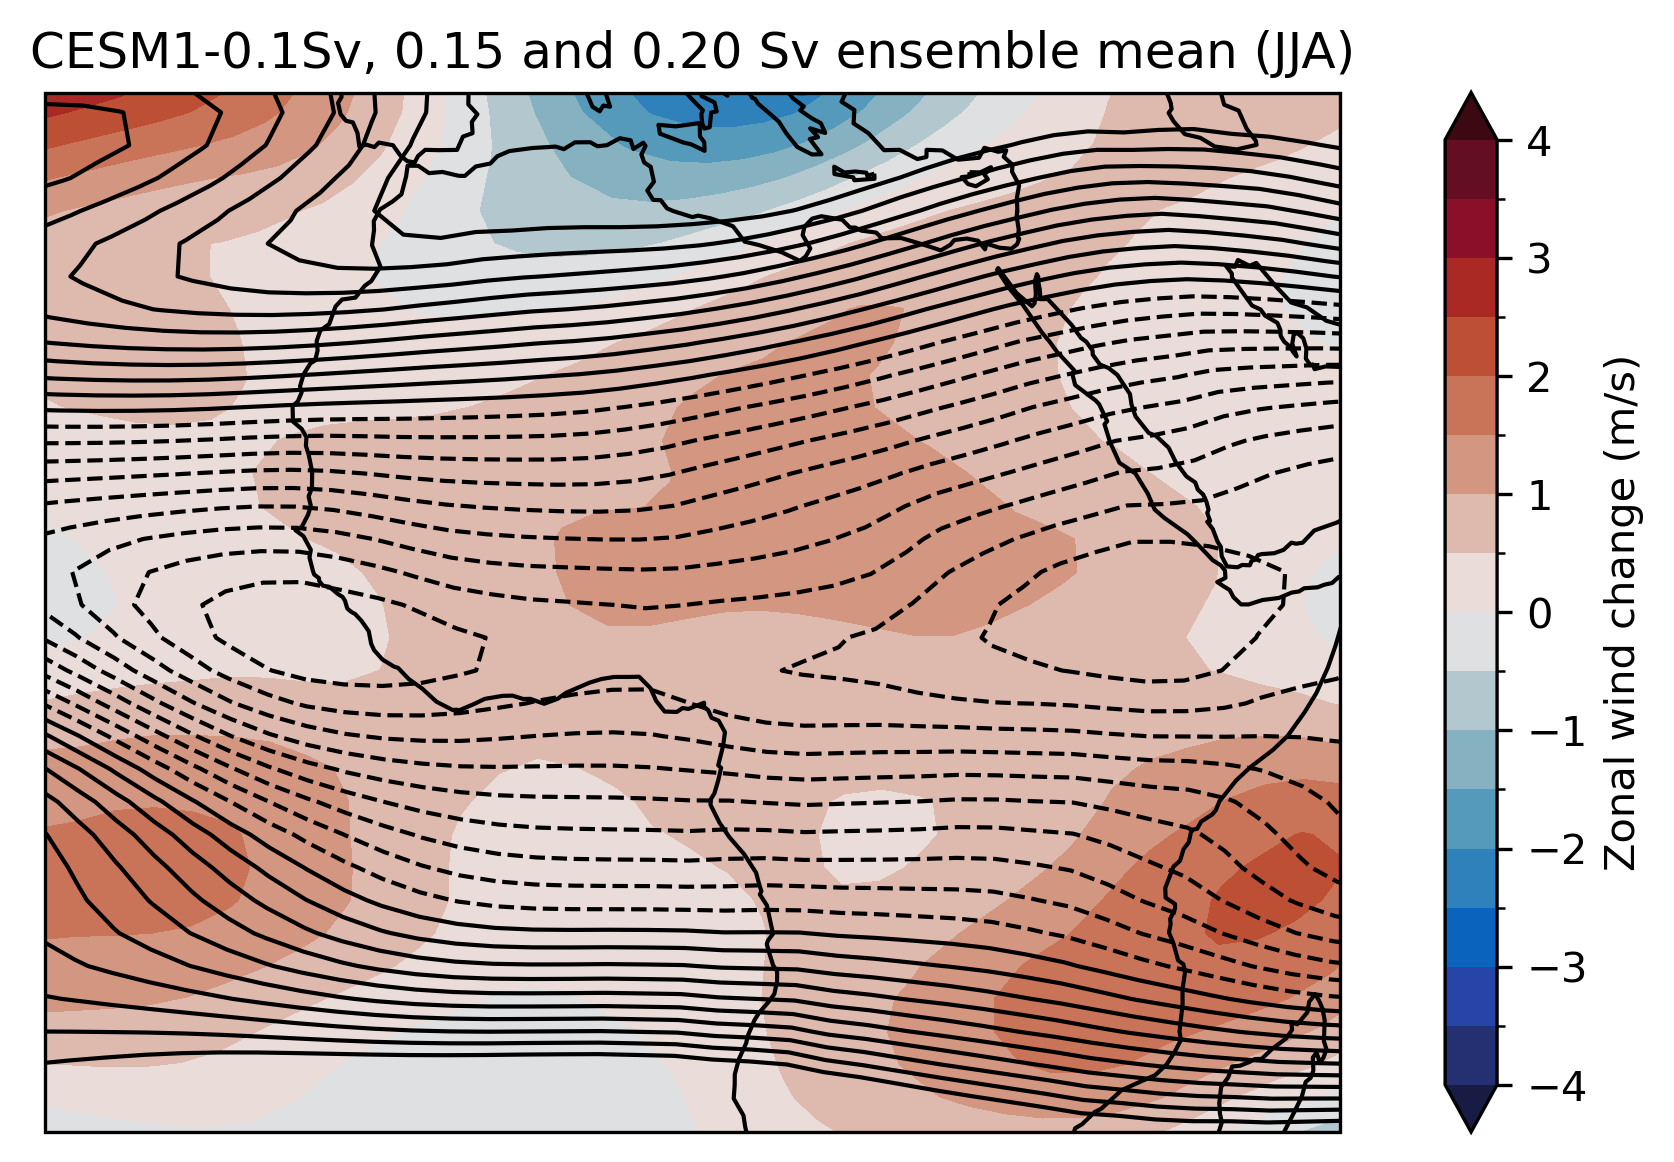

In [4]:
fig = plt.figure(figsize=(9, 4.5), dpi=300)
ax = plt.axes(projection = ccrs.Robinson(central_longitude=270))

# filled contour map of mean
cf = hose_CESM1_ens.plot.contourf(
    x = 'lon',
    y = 'lat',
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.balance, add_colorbar=True, levels = np.arange(-4,4.5, 0.5), cbar_kwargs={'label':'Zonal wind change (m/s)'})

cf = dsC_CESM1.plot.contour(
    x = 'lon',
    y = 'lat',
    ax=ax,
    transform=ccrs.PlateCarree(), levels = np.arange(-20, 20, 2), colors ='black', linewidths = 1)

# add coastlines
ax.coastlines()
ax.set_extent([-30, 50, -20, 40], crs=ccrs.PlateCarree())
ax.set_title('CESM1-0.1Sv, 0.15 and 0.20 Sv ensemble mean (JJA)')

<xarray.DataArray 'U' (lat: 96, lon: 145)>
array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [ 5.00487532e-02,  2.55044671e-02,  1.27367262e-04, ...,
         9.63336075e-02,             nan,             nan],
       ...,
       [-1.20845671e-01, -1.14576002e-01, -1.08848719e-01, ...,
        -1.34866948e-01,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan]])
Coordinates:
    lev      float64 197.9
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 175.0 177.5 180.0

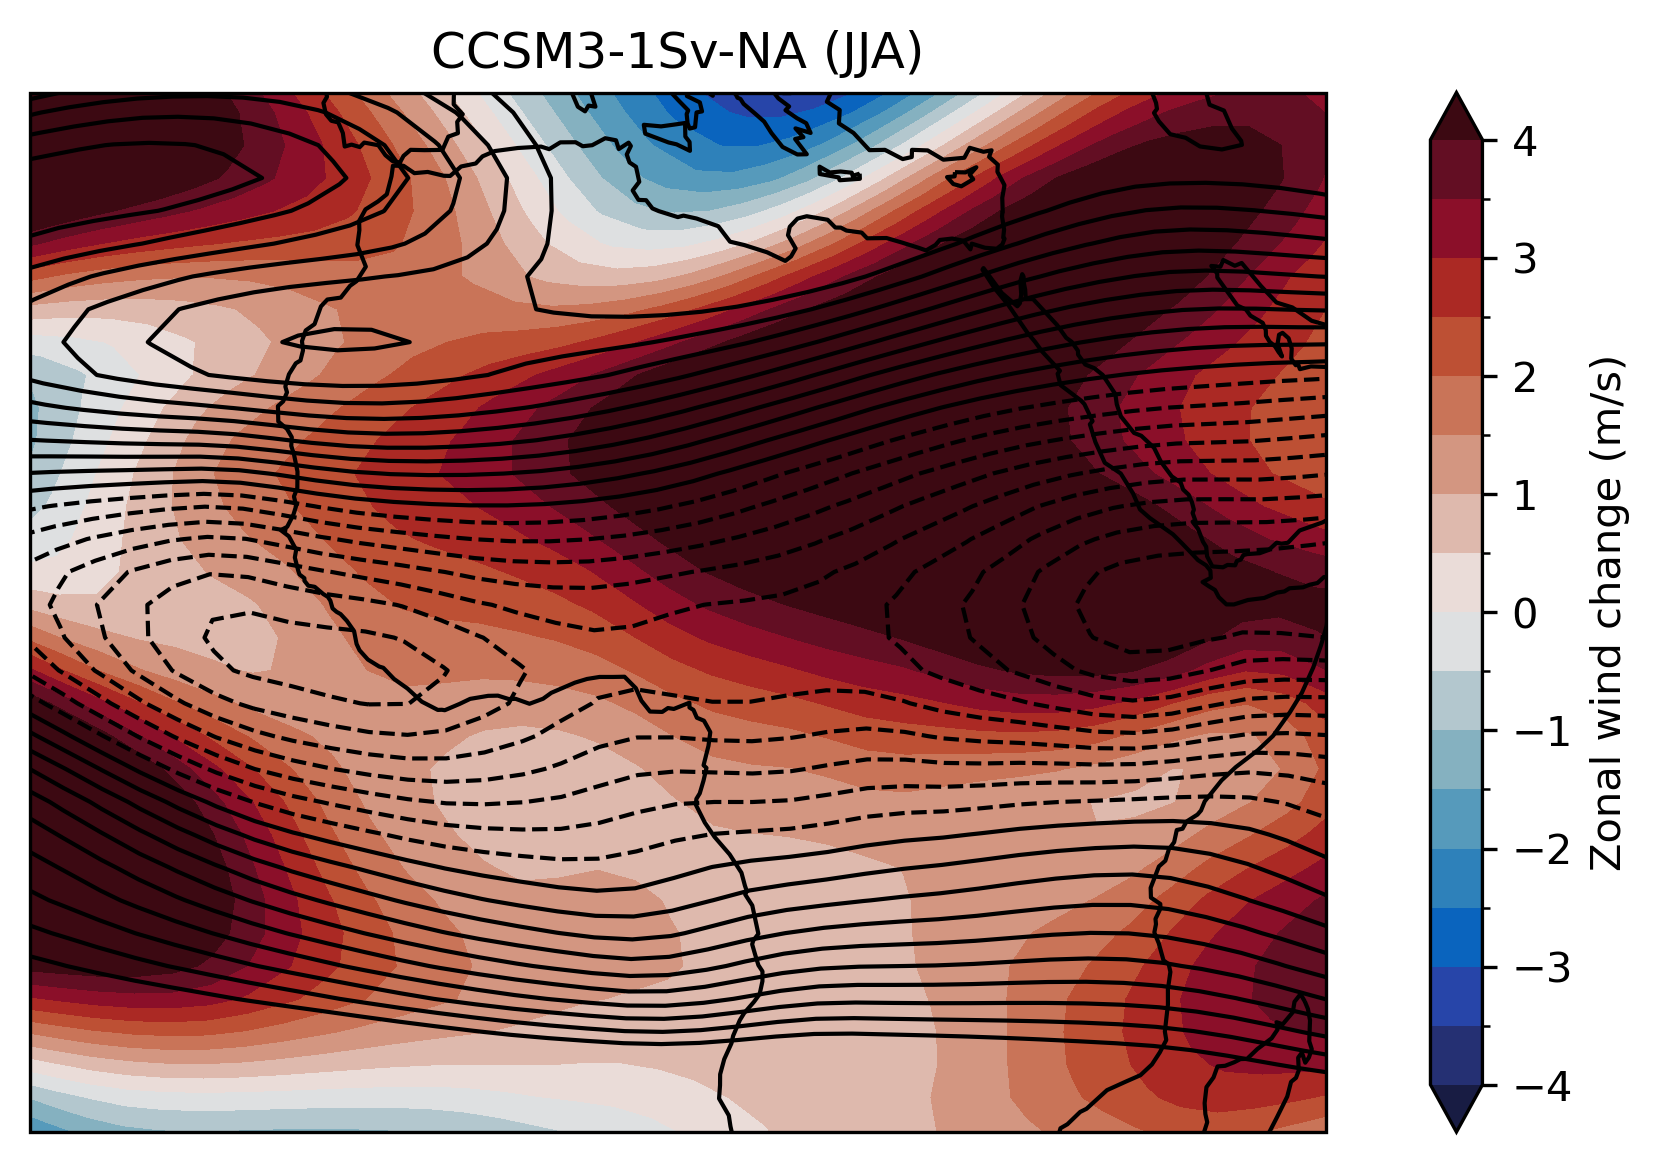

In [5]:
#-----------------------------------------------
# CCSM3-1Sv-NA
#-----------------------------------------------
# use 030001-039912 as LGM and 040001-049912 as HS1
fileC = '/Users/alawman2023/Documents/Data/Hosing/FromCJ/Freshwater Hosing experiments/CCSM3-1Sv-NA/b30.104w.cam.h0.U.030001-039912.nc'
fileH = '/Users/alawman2023/Documents/Data/Hosing/FromCJ/Freshwater Hosing experiments/CCSM3-1Sv-NA/b30.104w.ac1.cam.h0.U.040001-049912.nc'
#---LGM control---
dsC_CCSM3 = xr.open_dataset(fileC)
dsC_CCSM3 = fixTimeCESM(dsC_CCSM3)
# monthly climatology
dsC_CCSM3 = dsC_CCSM3.groupby(dsC_CCSM3.time.dt.month).mean()
# vertical interpolation to CESM1 levels
dsC_CCSM3 = dsC_CCSM3.interp(lev=new_lev, method="linear")

# horizontal interpolation to CESM1 grid
dsC_CCSM3 = dsC_CCSM3[climVar].sel(lev= selLev, method='nearest')
dsC_CCSM3 = adjustLon180(dsC_CCSM3)
dsC_CCSM3 = dsC_CCSM3.interp(lat=new_lats, lon=new_lons, method="linear")
dsC_CCSM3 = dsC_CCSM3[5:8].mean(dim='month') #JJA

#---Hosing---
dsH_CCSM3 = xr.open_dataset(fileH)
dsH_CCSM3 = fixTimeCESM(dsH_CCSM3)
# monthly climatology
dsH_CCSM3 = dsH_CCSM3.groupby(dsH_CCSM3.time.dt.month).mean()

# vertical intrpolation to CESM1 levels
dsH_CCSM3 = dsH_CCSM3.interp(lev=new_lev, method="linear")

# horizontal interpolation to CESM1 grid
dsH_CCSM3 = dsH_CCSM3[climVar].sel(lev= selLev, method='nearest')
dsH_CCSM3 = adjustLon180(dsH_CCSM3)
dsH_CCSM3 = dsH_CCSM3.interp(lat=new_lats, lon=new_lons, method="linear")
dsH_CCSM3 = dsH_CCSM3[5:8].mean(dim='month') #JJA

# hosing - control
hose_CCSM3 = dsH_CCSM3 - dsC_CCSM3

fig = plt.figure(figsize=(9, 4.5), dpi=300)
ax = plt.axes(projection = ccrs.Robinson(central_longitude=270))

# filled contour map of mean
cf = hose_CCSM3.plot.contourf(
    x = 'lon',
    y = 'lat',
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.balance, add_colorbar=True, levels = np.arange(-4,4.5, 0.5), cbar_kwargs={'label':'Zonal wind change (m/s)'})

cf = dsC_CCSM3.plot.contour(
    x = 'lon',
    y = 'lat',
    ax=ax,
    transform=ccrs.PlateCarree(), levels = np.arange(-20, 20, 2), colors ='black', linewidths = 1)

# add coastlines
ax.coastlines()
ax.set_extent([-30, 50, -20, 40], crs=ccrs.PlateCarree())
ax.set_title('CCSM3-1Sv-NA (JJA)')

hose_CCSM3

Text(0.5, 1.0, 'CESM1-iTraCE-MWF (JJA)')

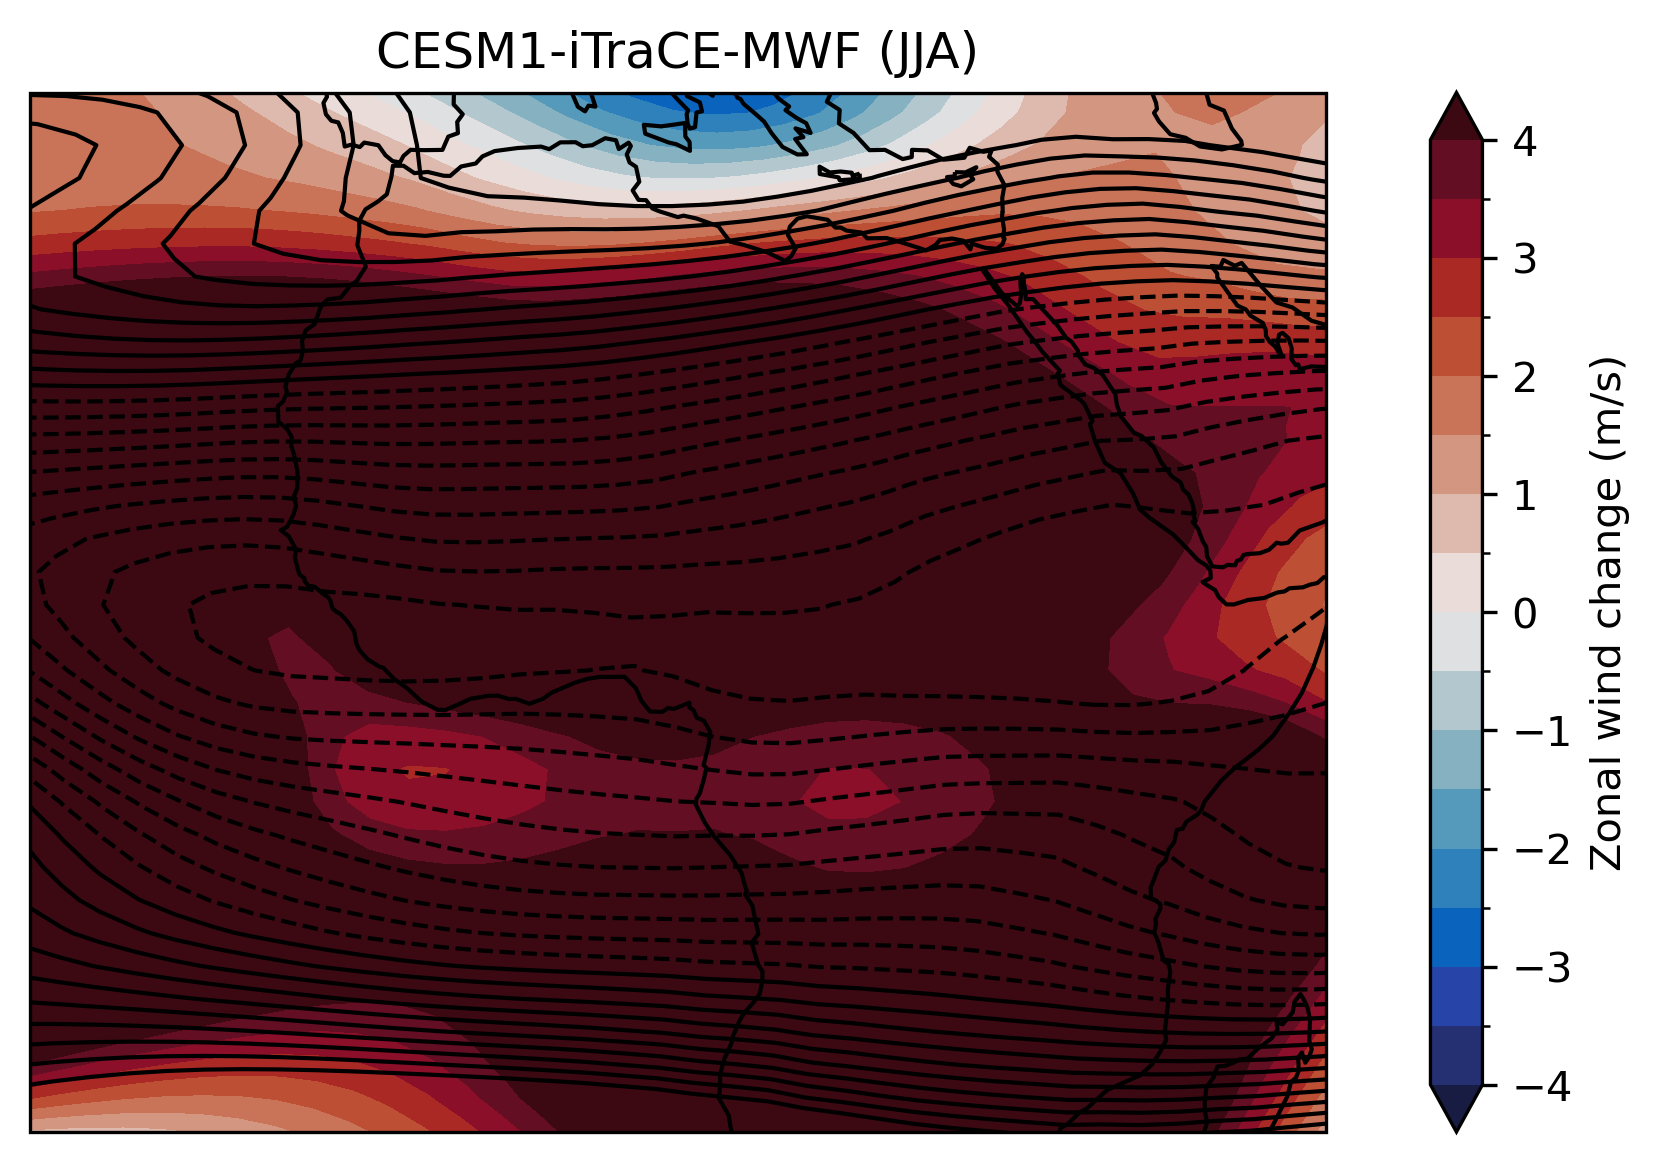

In [6]:
#-----------------------------------------------
# CESM1-iTraCE-MWF simulation
#-----------------------------------------------
fileWtr = '/Users/alawman2023/Documents/Data/iTRACE/ice_ghg_orb_wtr/climatology/b.e13.Bi1850C5.f19_g16.17-16ka.itrace.ice_ghg_orb_wtr.01.cam.h0.clim.300001-499912.nc'
fileNoWtr = '/Users/alawman2023/Documents/Data/iTRACE/ice_ghg_orb/climatology/b.e13.Bi1850C5.f19_g16.17-16ka.itrace.ice_ghg_orb.01.cam.h0.clim.300001-499912.nc'

# full forcing simulation (ice_ghg_orb_wtr)
dsWtr = xr.open_dataset(fileWtr)
dsWtr = adjustLon180(dsWtr)
dsWtr = add_cyclic_point_to_dataset(dsWtr, climVariTraCe)
dsWtr = dsWtr[climVariTraCe]
dsWtr = dsWtr[5:8].mean(dim='month') #JJA

# partial forcing simulation (ice_ghg_orb), use at the control simulation
dsC_iTraCE = xr.open_dataset(fileNoWtr)
dsC_iTraCE = adjustLon180(dsC_iTraCE)
dsC_iTraCE = add_cyclic_point_to_dataset(dsC_iTraCE, climVariTraCe)
dsC_iTraCE = dsC_iTraCE[climVariTraCe]
dsC_iTraCE = dsC_iTraCE[5:8].mean(dim='month') #JJA

hose_iTraCE = dsWtr - dsC_iTraCE
hose_iTraCE

# plot figure
fig = plt.figure(figsize=(9, 4.5), dpi=300)
ax = plt.axes(projection = ccrs.Robinson(central_longitude=270))

# filled contour map of mean
cf = hose_iTraCE.plot.contourf(
    x = 'lon',
    y = 'lat',
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.balance, add_colorbar=True, levels = np.arange(-4,4.5, 0.5), cbar_kwargs={'label':'Zonal wind change (m/s)'})

cf = dsC_iTraCE.plot.contour(
    x = 'lon',
    y = 'lat',
    ax=ax,
    transform=ccrs.PlateCarree(), levels = np.arange(-20, 20, 2), colors ='black', linewidths = 1)

# add coastlines
ax.coastlines()
ax.set_extent([-30, 50, -20, 40], crs=ccrs.PlateCarree())
ax.set_title('CESM1-iTraCE-MWF (JJA)')

Text(0.5, 1.0, 'IPSL-CM5 (JJA)')

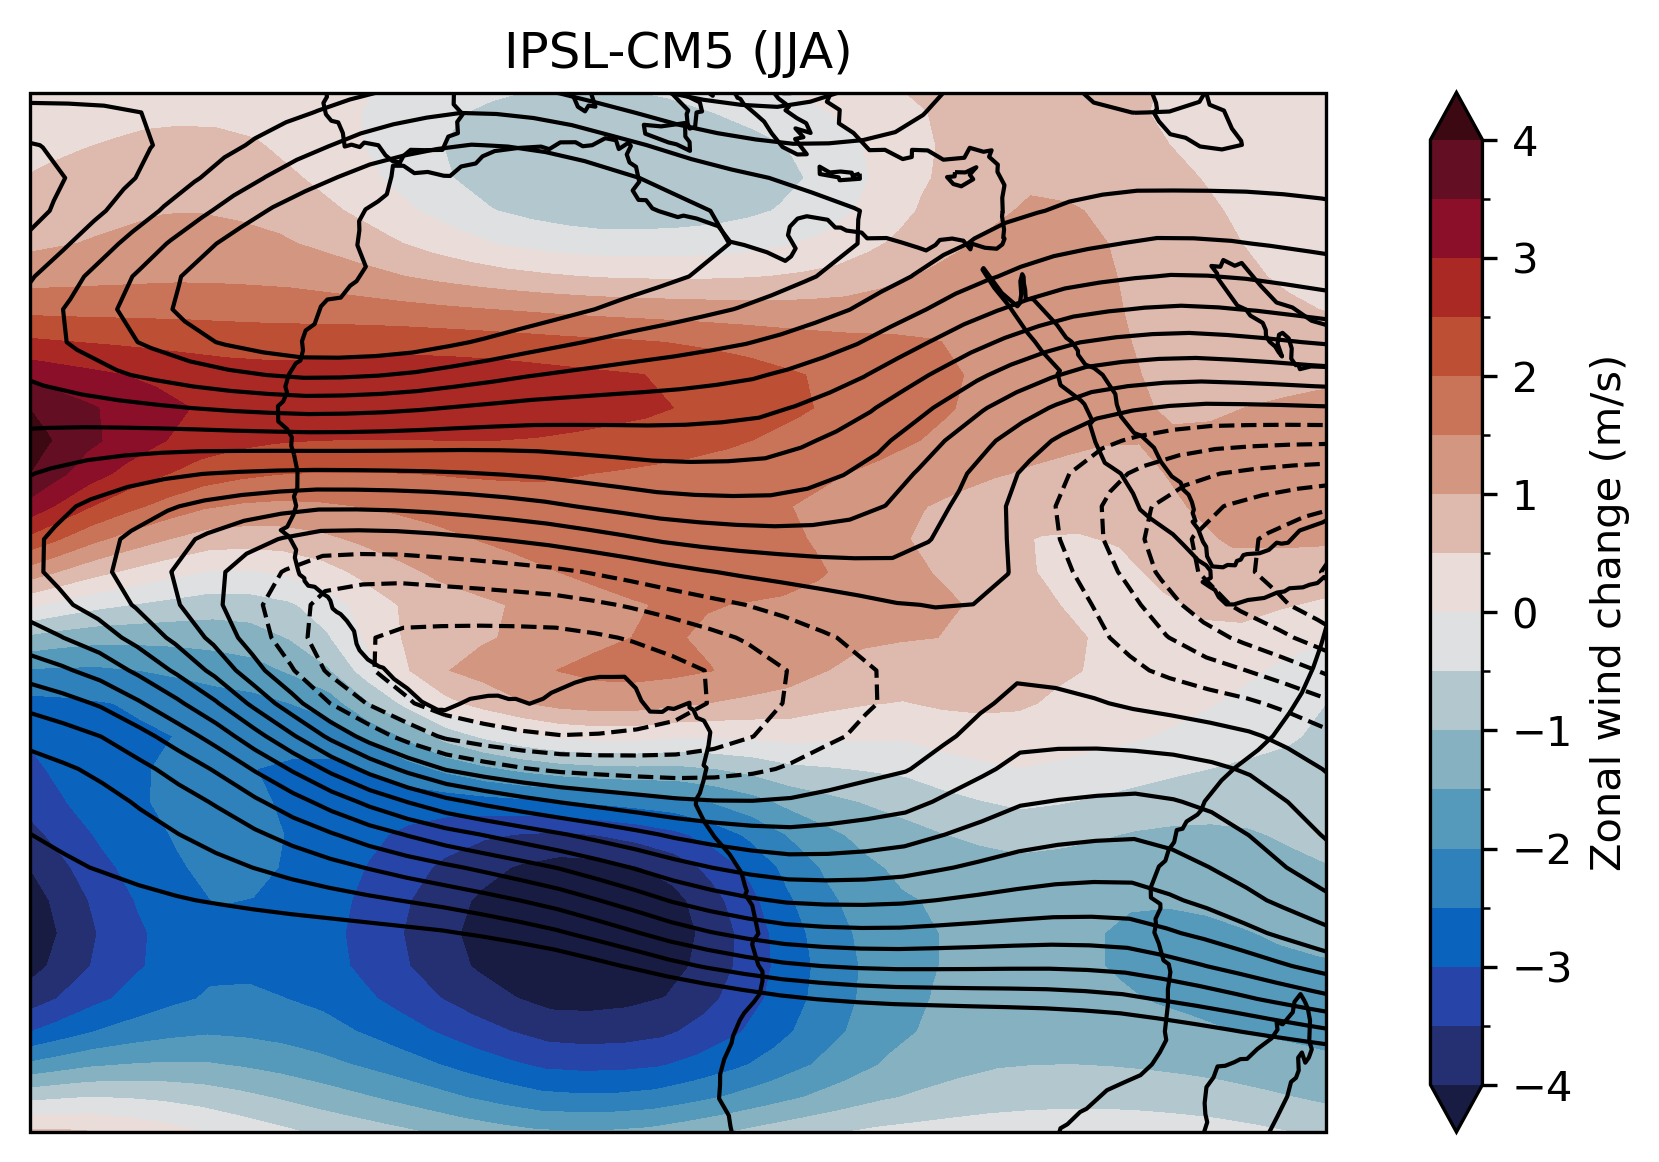

In [7]:
#-------------------------------------------
# IPSL-CM5 simulation
#-------------------------------------------
fileC = '/Users/alawman2023/Documents/Data/Hosing/FromCJ/Freshwater Hosing experiments/IPSL_CM5/lgm11c3_SE_3300_3399_1M_histmth.nc'
fileH = '/Users/alawman2023/Documents/Data/Hosing/FromCJ/Freshwater Hosing experiments/IPSL_CM5/lgm11f3_SE_3300_3399_1M_histmth.nc'

# control simulation --> load and interpolate to CESM grid
dsC_IPSL = xr.open_dataset(fileC)
dsC_IPSL = dsC_IPSL.interp(lat=new_lats, lon=new_lons, method="linear")

if climVarIPSL == 'u200':
    dsC_IPSL = dsC_IPSL[climVarIPSL]
elif climVarIPSL == 'u600':
    dsC_IPSL = dsC_IPSL['vitu'].sel(presnivs = 600*100, method ='nearest')

# hosing simulation --> load and interpolate to CESM grid
dsH_IPSL = xr.open_dataset(fileH)
dsH_IPSL = dsH_IPSL.interp(lat=new_lats, lon=new_lons, method="linear") 

if climVarIPSL == 'u200':
    dsH_IPSL = dsH_IPSL[climVarIPSL]
elif climVarIPSL == 'u600':
    dsH_IPSL = dsH_IPSL['vitu'].sel(presnivs = 600*100, method ='nearest')

# hosing - control
hose_IPSL = dsH_IPSL - dsC_IPSL

# JJA seasonal average
hose_IPSL = hose_IPSL[5:8].mean(dim='time_counter') #JJA
dsC_IPSL = dsC_IPSL[5:8].mean(dim='time_counter') #JJA

# plot figure
fig = plt.figure(figsize=(9, 4.5), dpi=300)
ax = plt.axes(projection = ccrs.Robinson(central_longitude=270))

# filled contour map of mean
cf = hose_IPSL.plot.contourf(
    x = 'lon',
    y = 'lat',
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.balance, add_colorbar=True, levels = np.arange(-4,4.5, 0.5), cbar_kwargs={'label':'Zonal wind change (m/s)'})

cf = dsC_IPSL.plot.contour(
    x = 'lon',
    y = 'lat',
    ax=ax,
    transform=ccrs.PlateCarree(), levels = np.arange(-20, 20, 2), colors ='black', linewidths = 1)

# add coastlines
ax.coastlines()
ax.set_extent([-30, 50, -20, 40], crs=ccrs.PlateCarree())
ax.set_title('IPSL-CM5 (JJA)')

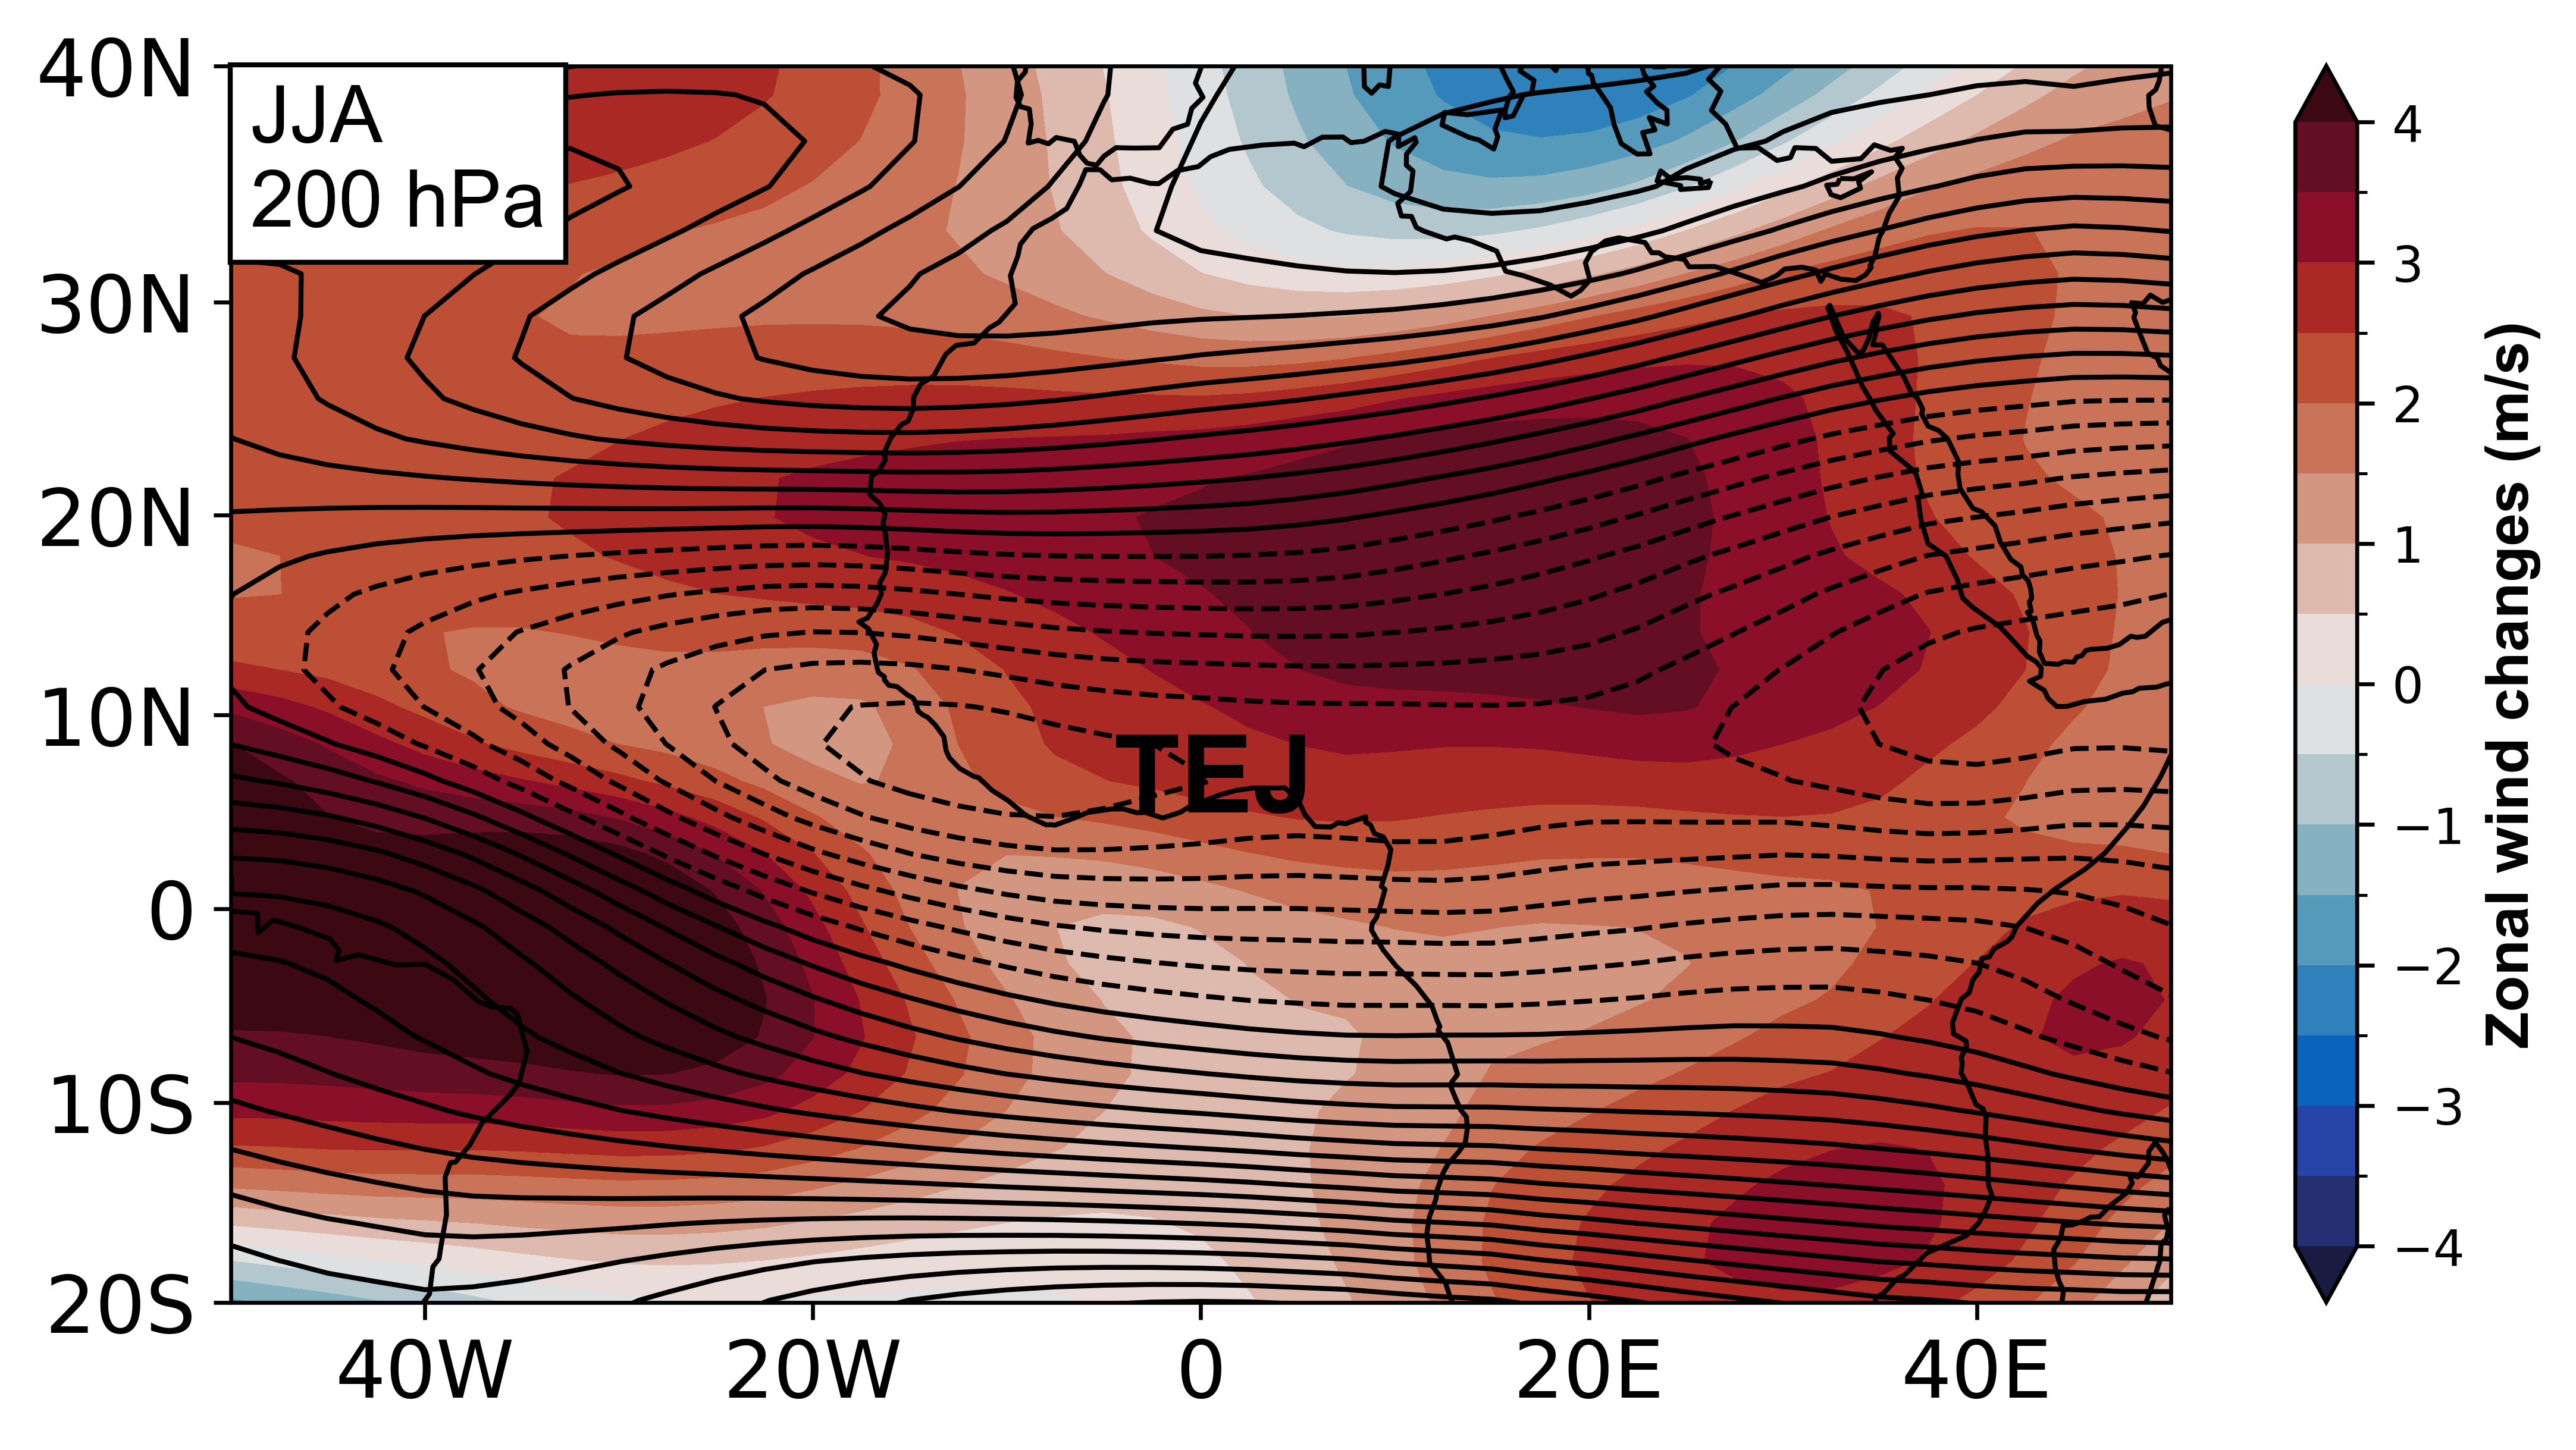

In [8]:
# ensemble mean
#ensembleH = (hose_CESM1_020 + hose_CCSM3 + hose_IPSL)/3
#ensembleC = (dsC_CESM1 + dsC_CCSM3 + dsC_IPSL)/3

ensembleH = (hose_CESM1_020 + hose_CCSM3 + hose_IPSL + hose_iTraCE)/4
ensembleC = (dsC_CESM1 + dsC_CCSM3 + dsC_IPSL + dsC_iTraCE)/4

from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)

# plot figure
fig = plt.figure(figsize=(9, 4.5), dpi=600)
ax = plt.axes(projection = ccrs.Mercator(central_longitude=0))

# filled contour map of mean
cf = ensembleH.plot.contourf(
    x = 'lon',
    y = 'lat',
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.balance, add_colorbar=False, levels = np.arange(-4,4.5, 0.5), extend = 'both') #np.arange(-4,4.5, 0.5)

cb = plt.colorbar(cf, orientation="vertical")
cb.set_label(label='Zonal wind changes (m/s)', size= 'large', weight='bold', font='Arial')

cf = ensembleC.plot.contour(
    x = 'lon',
    y = 'lat',
    ax=ax,
    transform=ccrs.PlateCarree(), levels = np.arange(-20, 40, 2), colors ='black', linewidths = 1)

# add coastlines
ax.coastlines()
ax.set_extent([-50, 50, -20, 40], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
ax.set_xticks([-40,-20, 0, 20, 40], crs=ccrs.PlateCarree())
ax.set_yticks([-20, -10, 0, 10, 20, 30, 40], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False, direction_label=True, degree_symbol='')
lat_formatter = LatitudeFormatter(degree_symbol='')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.tick_params(axis='both', labelsize=16)

gl.right_labels = False
gl.top_labels = False
gl.xlines = False
gl.ylines = False

# Remove the axis title
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('')

ax.text(0.01,0.87, 'JJA \n' + selLev + ' hPa', transform=ax.transAxes, bbox={'facecolor': 'white', 'edgecolor': 'black'}, font='Arial', fontsize = 16)

# annotate position of TEJ and AEJ
if selLev == '200':
    ax.text(-4.5, 5, 'TEJ', transform=ccrs.PlateCarree(), fontsize=22, color='black', weight='bold', font = 'Arial')
elif selLev == '600':
    ax.text(-22, 13, 'AEJ', transform=ccrs.PlateCarree(), fontsize=22, color='black', weight='bold', font = 'Arial')

fig.savefig("fig7-WestAfrica-jets-U" + selLev + '.png', facecolor = 'white', transparent = False, bbox_inches ='tight') 

In [9]:
"""
#-------------------------------------------
# IPSL-CM5 plots for reference
#-------------------------------------------

# control simulation --> load and interpolate to CESM grid
dsC_IPSL = xr.open_dataset(fileC)
dsC_IPSL = dsC_IPSL.interp(lat=new_lats, lon=new_lons, method="linear")

# hosing simulation --> load and interpolate to CESM grid
dsH_IPSL = xr.open_dataset(fileH)
dsH_IPSL = dsH_IPSL.interp(lat=new_lats, lon=new_lons, method="linear") 

# annual mean difference (pr)
hose_IPSL_pr = (dsH_IPSL['precip']*84600) - (dsC_IPSL['precip']*84600)
hose_IPSL_pr = hose_IPSL_pr.mean(dim='time_counter')

# annual mean difference (surface temperature, ts)
hose_IPSL_ts = (dsH_IPSL['tsol']-273.15) - (dsC_IPSL['tsol']-273.15)
hose_IPSL_ts = hose_IPSL_ts.mean(dim='time_counter')

# annual mean difference and JJA difference (u200)
hose_IPSL_u200 = dsH_IPSL['u200'] - dsC_IPSL['u200']
hose_IPSL_u200 = hose_IPSL_u200.mean(dim='time_counter')

# plot global maps
ax = plotWorldMap(hose_IPSL_pr, cmocean.cm.tarn, np.arange(-1.8, 2, 0.2), 'Precipitation change (mm/day)')
ax.set_title('IPSL-CM5 Annual Mean Precipitation Change')

ax = plotWorldMap(hose_IPSL_ts, cmocean.cm.balance, np.arange(-12, 13, 1), 'Temperature change (°C)')
ax.set_title('IPSL-CM5 Annual Mean Temperature Change')

ax = plotWorldMap(hose_IPSL_u200, cmocean.cm.balance, np.arange(-4, 4.5, 0.5), 'Zonal mean wind change (m/s)')
ax.set_title('IPSL-CM5 Annual Mean U200 Change')
"""

'\n#-------------------------------------------\n# IPSL-CM5 plots for reference\n#-------------------------------------------\n\n# control simulation --> load and interpolate to CESM grid\ndsC_IPSL = xr.open_dataset(fileC)\ndsC_IPSL = dsC_IPSL.interp(lat=new_lats, lon=new_lons, method="linear")\n\n# hosing simulation --> load and interpolate to CESM grid\ndsH_IPSL = xr.open_dataset(fileH)\ndsH_IPSL = dsH_IPSL.interp(lat=new_lats, lon=new_lons, method="linear") \n\n# annual mean difference (pr)\nhose_IPSL_pr = (dsH_IPSL[\'precip\']*84600) - (dsC_IPSL[\'precip\']*84600)\nhose_IPSL_pr = hose_IPSL_pr.mean(dim=\'time_counter\')\n\n# annual mean difference (surface temperature, ts)\nhose_IPSL_ts = (dsH_IPSL[\'tsol\']-273.15) - (dsC_IPSL[\'tsol\']-273.15)\nhose_IPSL_ts = hose_IPSL_ts.mean(dim=\'time_counter\')\n\n# annual mean difference and JJA difference (u200)\nhose_IPSL_u200 = dsH_IPSL[\'u200\'] - dsC_IPSL[\'u200\']\nhose_IPSL_u200 = hose_IPSL_u200.mean(dim=\'time_counter\')\n\n# plot glo

In [10]:
'''
# IPSL control simulation --> load and interpolate to CESM grid
dsC_IPSL = xr.open_dataset(fileC)
dsC_IPSL = dsC_IPSL.interp(lat=new_lats, lon=new_lons, method="linear")

#dsC_CESM1 = dsC_CESM1[climVar].sel(lev= selLev, method='nearest')
dsC_IPSL['vitu'].sel(presnivs = 600*100, method ='nearest')
'''

'\n# IPSL control simulation --> load and interpolate to CESM grid\ndsC_IPSL = xr.open_dataset(fileC)\ndsC_IPSL = dsC_IPSL.interp(lat=new_lats, lon=new_lons, method="linear")\n\n#dsC_CESM1 = dsC_CESM1[climVar].sel(lev= selLev, method=\'nearest\')\ndsC_IPSL[\'vitu\'].sel(presnivs = 600*100, method =\'nearest\')\n'

In [11]:
'''
# CESM1 control simulation
fileC = 'b.e12.B1850C5.f19_g16.21ka.010.cam.clim.0001-0600.nc'
dsC_CESM1 = xr.open_dataset(dataPath + fileC)
for i in range(0,12):
    # plot figure
    fig = plt.figure(figsize=(9, 4.5), dpi=300)
    ax = plt.axes(projection = ccrs.Robinson(central_longitude=270))
    
    # filled contour map of mean
    tmp = dsC_CESM1['PRECT'][i]*84600*1000
    cf = tmp.plot.contourf(
        x = 'lon',
        y = 'lat',
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmocean.cm.rain, add_colorbar=True, levels = np.arange(0,14, 0.5), cbar_kwargs={'label':'Precipitation (mm/day)'})
    ax.set_title(str(i))
    #fig.savefig(str(i)+ ".png", facecolor = 'white', transparent = False, bbox_inches ='tight') 

'''

'\n# CESM1 control simulation\nfileC = \'b.e12.B1850C5.f19_g16.21ka.010.cam.clim.0001-0600.nc\'\ndsC_CESM1 = xr.open_dataset(dataPath + fileC)\nfor i in range(0,12):\n    # plot figure\n    fig = plt.figure(figsize=(9, 4.5), dpi=300)\n    ax = plt.axes(projection = ccrs.Robinson(central_longitude=270))\n\n    # filled contour map of mean\n    tmp = dsC_CESM1[\'PRECT\'][i]*84600*1000\n    cf = tmp.plot.contourf(\n        x = \'lon\',\n        y = \'lat\',\n        ax=ax,\n        transform=ccrs.PlateCarree(),\n        cmap=cmocean.cm.rain, add_colorbar=True, levels = np.arange(0,14, 0.5), cbar_kwargs={\'label\':\'Precipitation (mm/day)\'})\n    ax.set_title(str(i))\n    #fig.savefig(str(i)+ ".png", facecolor = \'white\', transparent = False, bbox_inches =\'tight\') \n\n'